File used for testing the functions in the repository

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import pandas as pd

In [2]:
# import predict_polynomial_signal from Predicted_signal.py
from source.Losses import MSE, compute_parameter_loss
from source.Predicted_signal import predict_polynomial
from data.Polynomial_test import generate_polynomial_data
from data.Polynomial_test import load_polynomial_data

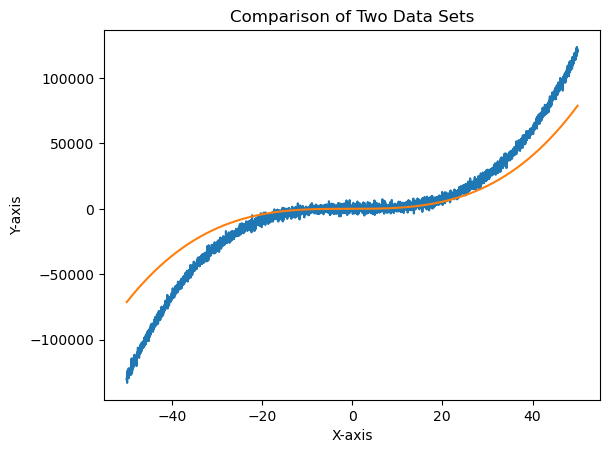

MSE: 374675842.8138398


In [3]:
# Coefficients for the polynomial (a0, a1, a2, a3, a4)
true_coefficients = [250, 2.5, -2, 1]
list = np.linspace(-50, 50, 5000)
estimated_coefficients = [0, 1.2, 1.5, 0.6]

result = generate_polynomial_data(true_coefficients, list, noise_level=2000)
prediction = predict_polynomial(estimated_coefficients, list)

plt.plot(list, result)
plt.plot(list, prediction)

plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Comparison of Two Data Sets')

plt.show()

print("MSE:", MSE(result, prediction))

In [4]:
# Get two tensors

a = np.array([1, 2, 3, 4, -7])
b = np.array([1, 2, 3, 4, 5])

inputs_tensor = torch.tensor(a, dtype=torch.float32)
true_params_tensor = torch.tensor(b, dtype=torch.float32)


print("Parameter Loss:", compute_parameter_loss(inputs_tensor, true_params_tensor))

Parameter Loss: tensor(-2.4000)


In [5]:
print(np.random.randn(4))

[ 0.43069736  0.04964198  0.51328468 -0.73700063]


<h2>Generating simulated data<h2>

In [6]:
from data.Data_simulation import DataLoader

In [7]:
# Load the file into a pandas DataFrame
df = pd.read_csv('data/all_data_003.csv')

# Usage example:
data_from_first_row = DataLoader(0, df)

# Output the data extracted from the first row to verify the DataLoader function
print(data_from_first_row)

{'rtim_list': [0.125, 0.291667, 0.375, 0.458333, 0.583333, 0.75, 0.916667, 1.5, 2.5, 3.5, 4.5, 6.25, 8.75, 12.5, 17.5, 25, 35, 45, 55, 65, 75, 85], 'pl_list': [0.05901, 0.0550587, 110.023, 83.0705, 55.6943, 44.4686, 36.9873, 27.5891, 13.5464, 6.33916, 3.52664, 2.49758, 1.44494, 1.04103, 0.71615, 0.52742, 0.43791, 0.35239, 0.32866, 0.27326, 0.26068, 0.24129], 'bl_list': [0.08737, 0.081723, 164.763, 125.181, 84.5654, 68.4428, 58.1711, 44.4919, 24.3138, 14.0272, 9.47834, 7.88443, 5.59859, 4.81384, 3.79608, 3.04436, 2.67881, 2.23747, 2.13455, 1.80559, 1.74821, 1.63998], 'tac_list': [0.125549, 4.5012, 13.7206, 9.70757, 9.24363, 8.84905, 8.37535, 7.8264, 7.84643, 8.74946, 8.4736, 8.5893, 9.00677, 8.93431, 8.7004, 8.79878, 8.63712, 8.86024, 8.56235, 8.77035, 8.93855, 8.96577], 'gt_parameters_list': [0.13, 0.014, 0.025, 0.05]}


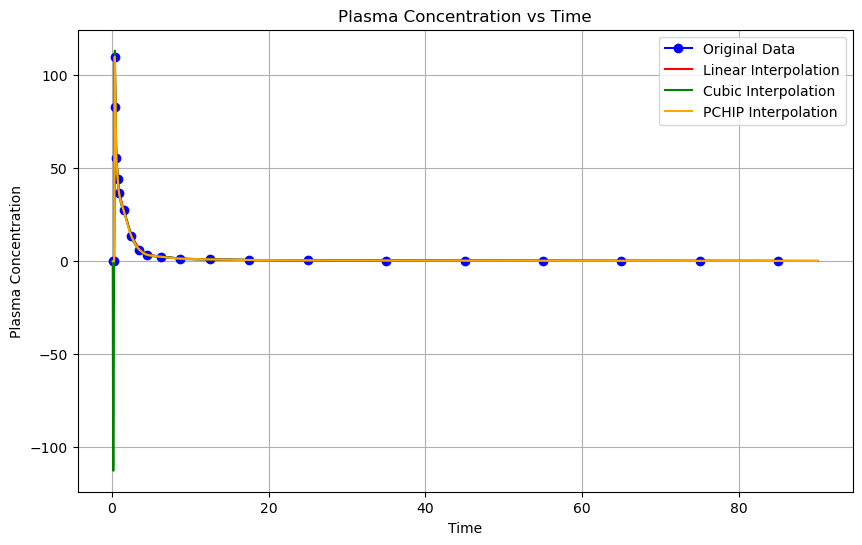

In [33]:
from data.Data_simulation import equidistant_interpolation, plot_interpolations

num_equidistant_points = 10000
new_rtim, linear_pl, cubic_pl, pchip_pl = equidistant_interpolation(data_from_first_row['rtim_list'],
                                                          data_from_first_row['pl_list'],
                                                          num_equidistant_points)

plot_interpolations(data_from_first_row['rtim_list'], 
                    data_from_first_row['pl_list'], 
                    new_rtim, linear_pl, cubic_pl, pchip_pl, 'Plasma')

<h3> IRF <h3>

In [9]:
from data.Data_simulation import IRF

IRF_values = IRF(data_from_first_row['gt_parameters_list'], new_rtim)

print("Parameters:", data_from_first_row['gt_parameters_list'])
print(IRF_values)

Parameters: [0.13, 0.014, 0.025, 0.05]
[0.12977305363123387, 0.1297567771538463, 0.1297405063811381, 0.1297242413111099, 0.12970798194176297, 0.12969172827109932, 0.1296754802971217, 0.12965923801783336, 0.1296430014312385, 0.1296267705353419, 0.129610545328149, 0.12959432580766603, 0.12957811197189986, 0.1295619038188581, 0.129545701346549, 0.12952950455298157, 0.12951331343616546, 0.1294971279941111, 0.12948094822482945, 0.1294647741263324, 0.1294486056966324, 0.1294324429337426, 0.12941628583567683, 0.12940013440044967, 0.12938398862607636, 0.12936784851057292, 0.12935171405195592, 0.1293355852482427, 0.12931946209745135, 0.1293033445976005, 0.1292872327467097, 0.12927112654279901, 0.12925502598388922, 0.12923893106800186, 0.12922284179315913, 0.1292067581573839, 0.12919068015869975, 0.129174607795131, 0.1291585410647026, 0.12914247996544023, 0.1291264244953702, 0.1291103746525196, 0.12909433043491614, 0.12907829184058828, 0.1290622588675651, 0.1290462315138764, 0.12903020977755272,

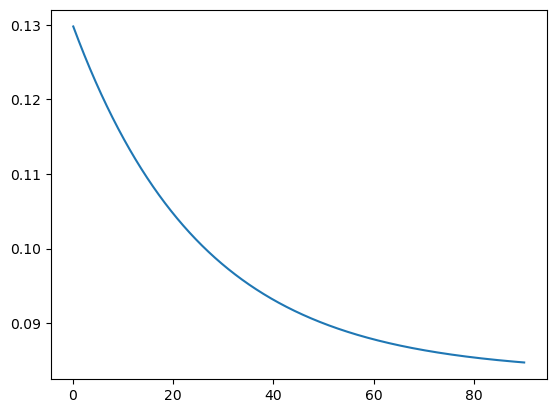

In [49]:
plt.plot(new_rtim, IRF_values)
#plt.plot(new_rtim, linear_pl)
plt.show()

In [56]:
print(data_from_first_row['gt_parameters_list'])

k1 = data_from_first_row['gt_parameters_list'][0]
k2 = data_from_first_row['gt_parameters_list'][1]
k3 = data_from_first_row['gt_parameters_list'][2]
k4 = 0
print((k2 + k3 + k4))
alpha1 = (k2 + k3 + k4) - np.sqrt((k2 + k3 + k4)**2 - 4*k2*k4)
print(alpha1)
alpha1 /= 2

print(alpha1)

alpha2 = (k2 + k3 + k4) + np.sqrt((k2 + k3 + k4)**2 - 4*k2*k4)
print(alpha2)
alpha2 /= 2
print(alpha2)

print(np.exp(alpha1*0.1))

[0.13, 0.014, 0.025, 0.05]
0.039
0.0
0.0
0.078
0.039
1.0


In [ ]:
def IRF(gt_parameters_list, equidistant_rtim):
    """
    Calculates the impulse response function (IRF) for the given ground truth parameters and equidistant timepoints.

    Parameters:
    gt_parameters_list (list): List of ground truth parameters.
    equidistant_rtim (list): Equidistant timepoints.

    Returns:
    list: The IRF values.
    """
    # Extract ground truth parameters
    k1 = gt_parameters_list[0]
    k2 = gt_parameters_list[1]
    k3 = gt_parameters_list[2]
    k4 = 0 # For the current data, k4 is always 0

    # Calculate alphas:
    alpha1 = (k2 + k3 + k4) - np.sqrt((k2 + k3 + k4)**2 - 4*k2*k4)
    alpha1 /= 2

    alpha2 = (k2 + k3 + k4) + np.sqrt((k2 + k3 + k4)**2 - 4*k2*k4)
    alpha2 /= 2

    # Calculate IRF
    IRF = []
    for t in equidistant_rtim:
        value = ( (k3 + k4 - alpha1) * np.exp(-alpha1 * t) + (alpha2 - k3 - k4) * np.exp(-alpha2 * t) ) / (alpha2 - alpha1)
        value *= k1
        IRF.append(value)
    
    return IRF

<h2> C Tissue <h2>

In [11]:
def c_tissue(IRF_values, pchip_pl):
    """
    Calculates the simulated TAC values for the given IRF and plasma concentration values.

    Parameters:
    IRF_values (list): The IRF values.
    pchip_pl (list): Plasma concentration values interpolated using PCHIP.

    Returns:
    list: The simulated TAC values.
    """
    # Convert lists to PyTorch tensors and add required dimensions for conv1d
    IRF_tensor = torch.tensor(IRF_values).float().unsqueeze(0).unsqueeze(0)
    pchip_pl_tensor = torch.tensor(pchip_pl).float().unsqueeze(0).unsqueeze(0)

    # Perform the convolution using PyTorch's conv1d function
    # The groups argument ensures that each input channel is convolved with its own filter (IRF_tensor)
    result_tensor = F.conv1d(pchip_pl_tensor, IRF_tensor, padding='same', groups=1)

    # Remove the extra dimensions and convert the tensor back to a list
    simulated_tac_values = result_tensor.squeeze().tolist()

    return simulated_tac_values

In [12]:
def c_tissue2(IRF_values, pchip_pl):
    """
    Calculates the simulated TAC values for the given IRF and plasma concentration values.

    Parameters:
    IRF_values (list): The IRF values.
    pchip_pl (list): Plasma concentration values interpolated using PCHIP.

    Returns:
    list: The simulated TAC values.
    """
    # Convert lists to PyTorch tensors and add batch and channel dimensions (required for conv1d)
    # The unsqueeze(0) adds a batch dimension and unsqueeze(1) adds a channel dimension.
    irf_tensor = torch.tensor(IRF_values).float().unsqueeze(0).unsqueeze(0)
    pchip_tensor = torch.tensor(pchip_pl).float().unsqueeze(0).unsqueeze(0)

    # Perform the convolution
    # The conv1d function expects inputs of size (minibatch, in_channels, iW), where
    # minibatch is the number of input maps, in_channels is the number of channels in the input image,
    # and iW is the width of the input image.
    result_tensor = F.conv1d(pchip_tensor, irf_tensor, padding='same')

    # Convert the result back to a list and remove the extra dimensions
    simulated_tac_values = result_tensor.squeeze().tolist()

    return simulated_tac_values

In [25]:
def c_tissue3(IRF_values, pchip_pl):
    # Convert lists to PyTorch tensors
    irf_tensor = torch.tensor(IRF_values).float().view(1, 1, -1)
    pchip_tensor = torch.tensor(pchip_pl).float().view(1, 1, -1)

    # Check if the IRF tensor length is odd, if not, append a zero
    if irf_tensor.shape[-1] % 2 == 0:
        # Append a zero to make the length odd
        irf_tensor = F.pad(irf_tensor, (0, 1))
    
    # Perform the convolution
    result_tensor = F.conv1d(pchip_tensor, irf_tensor, padding='same')

    # Convert the result back to a list
    simulated_tac_values = result_tensor.squeeze().tolist()

    return simulated_tac_values

<h3> Numpy <h3>

In [42]:
def c_tissue4(IRF_values, pchip_pl):
    """
    Calculates the simulated C_Tissue values for the given IRF and plasma concentration values.

    Parameters:
    IRF_values (list): The IRF values.
    pchip_pl (list): Plasma concentration values interpolated using PCHIP.

    Returns:
    list: The simulated C_Tissue values.
    """

    # Compute the convolution of the two lists
    simulated_c_tissue_values = np.convolve(IRF_values, pchip_pl, mode='same')

    return simulated_c_tissue_values.tolist()

In [43]:
simulated_c_tissue_values = c_tissue4(IRF_values, pchip_pl)

print("pl_chip:", len(pchip_pl))
print("IRF:", len(IRF_values))

print(simulated_c_tissue_values)
print(len(simulated_c_tissue_values))


pl_chip: 10000
IRF: 10000
[1269.9530845748664, 1269.946938215048, 1269.9408000212131, 1269.9346699970486, 1269.9285481462302, 1269.9224344724191, 1269.9163289792632, 1269.9102316703998, 1269.9041425494534, 1269.8980616200342, 1269.8919888857422, 1269.885924350165, 1269.8798680168732, 1269.8738198894293, 1269.8677799713842, 1269.86174826627, 1269.8557247776141, 1269.8497095089244, 1269.8437024637021, 1269.8377036454322, 1269.8317130575876, 1269.825730703628, 1269.8197565870053, 1269.8137907111525, 1269.8078330794938, 1269.801883695441, 1269.7959425623903, 1269.7900096837284, 1269.7840850628284, 1269.7781687030524, 1269.772260607746, 1269.7663607802467, 1269.7604692238774, 1269.7545859419479, 1269.7487109377576, 1269.7428442145901, 1269.7369857757192, 1269.7311356244063, 1269.7252937638998, 1269.7194601974327, 1269.7136349282302, 1269.7078179595028, 1269.7020092944474, 1269.6962089362507, 1269.6904168880842, 1269.68463315311, 1269.6788577344748, 1269.6730906353146, 1269.6673318587532, 12

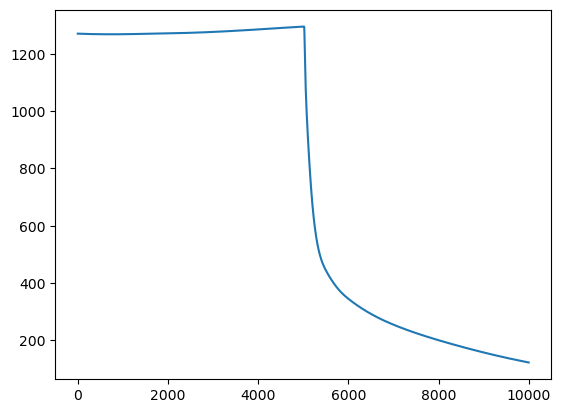

In [44]:
# Plot c_tissue4 values

plt.plot(simulated_c_tissue_values)
plt.show()

<h3> Scipy <h3>

In [45]:
import scipy.signal

def c_tissue5(IRF_values, pchip_pl):
    """
    Calculates the simulated C_Tissue values for the given IRF and plasma concentration values.

    Parameters:
    IRF_values (list): The IRF values.
    pchip_pl (list): Plasma concentration values interpolated using PCHIP.

    Returns:
    list: The simulated C_Tissue values.
    """

    # Compute the convolution of the two lists
    simulated_c_tissue_values = scipy.signal.convolve(IRF_values, pchip_pl, mode='full')

    return simulated_c_tissue_values


In [46]:
simulated_c_tissue_values = c_tissue5(IRF_values, pchip_pl)

print("pl_chip:", len(pchip_pl))
print("IRF:", len(IRF_values))

print(simulated_c_tissue_values)
print(len(simulated_c_tissue_values))

pl_chip: 10000
IRF: 10000
[0.00765791 0.01523629 0.02274361 ... 0.05829415 0.03886075 0.01942937]
19999


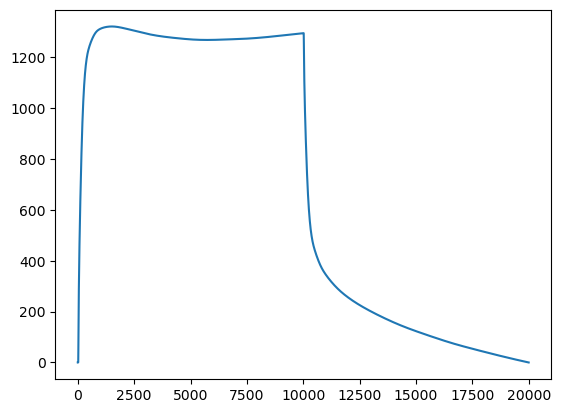

In [47]:
plt.plot(simulated_c_tissue_values)
plt.show()

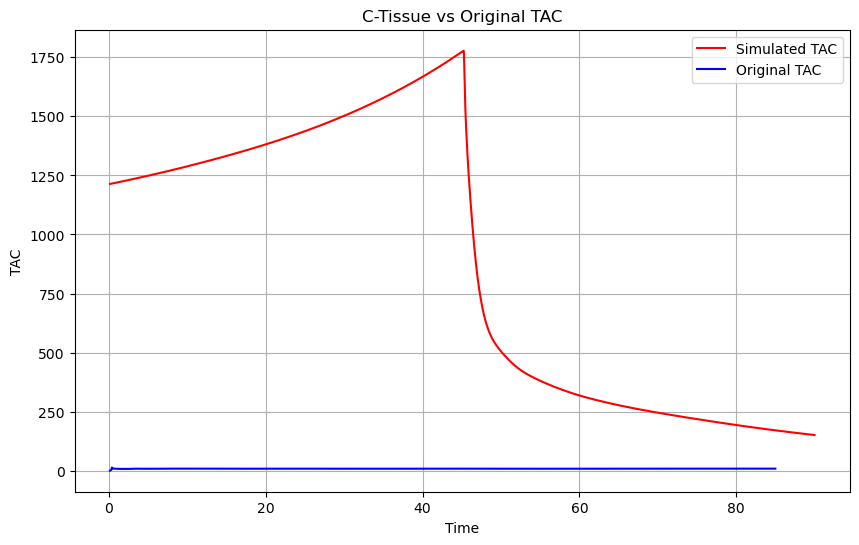

In [50]:
simulated_c_tissue_values = c_tissue(IRF_values, pchip_pl)

# Plot the simulated C_Tissue values against the original TAC values
plt.figure(figsize=(10, 6))
plt.plot(new_rtim, simulated_c_tissue_values, label='Simulated TAC', color='red')
plt.plot(data_from_first_row['rtim_list'], data_from_first_row['tac_list'], label='Original TAC', color='blue')
plt.xlabel('Time')
plt.ylabel('TAC')
plt.title('C-Tissue vs Original TAC')
plt.legend()
plt.grid(True)
plt.show()

<h2>Simulated TAC <h2>

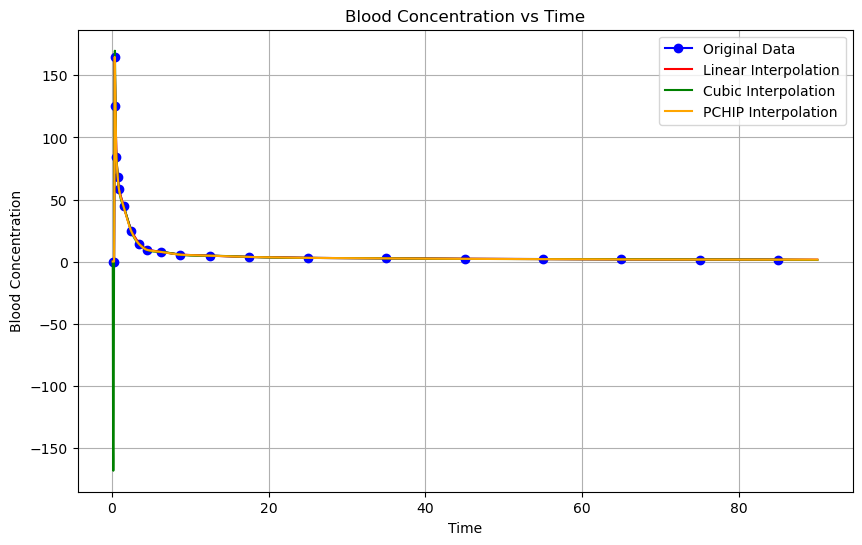

In [15]:
# Get the interpolated blood values
new_rtim, linear_bl, cubic_bl, pchip_bl = equidistant_interpolation(data_from_first_row['rtim_list'],
                                                          data_from_first_row['bl_list'],
                                                          num_equidistant_points)

plot_interpolations(data_from_first_row['rtim_list'], 
                    data_from_first_row['bl_list'], 
                    new_rtim, linear_bl, cubic_bl, pchip_bl, 'Blood')

In [17]:
print("Blood values:", len(pchip_bl))
print("C_tissue", len(simulated_c_tissue_values))
print("vb:", data_from_first_row['gt_parameters_list'][3])

Blood values: 10000
C_tissue 10000
vb: 0.05


In [18]:
def simulated_tac(c_tissue, gt_parameters_list, bl_list):
    """
    Calculates the simulated TAC values for the given C_Tissue and blood concentration values.

    Parameters:
    c_tissue (list): The C_Tissue values.
    gt_parameters_list (list): The ground truth parameters.
    bl_list (list): Blood concentration values.

    Returns:
    list: The simulated TAC values.
    """
    simulated_tac_values = []
    vb = gt_parameters_list[3]

    for i in range(len(c_tissue)):
        value = c_tissue[i] * (1-vb) + vb * bl_list[i]
        simulated_tac_values.append(value)
    
    return simulated_tac_values
    

Simulated TAC: [1152.9618025820312, 1153.0200906185478, 1153.0791950841628, 1153.1378400783833, 1153.1960253354812, 1153.2554900916814, 1153.3142626457095, 1153.3745461009783, 1153.4327452210562, 1153.4936143788875, 1153.5511230353068, 1153.6095616960704, 1153.6690460622474, 1153.7276044325629, 1153.7882516780078, 1153.8477404625414, 1153.9071142216083, 1153.966256722683, 1154.025167700038, 1154.1402910161933, 1154.6880260814546, 1155.6285354640613, 1156.8399152042057, 1158.197130238565, 1159.577000972567, 1160.8540284757012, 1161.9045692862073, 1162.6072992782629, 1162.8443011761578, 1162.8396047541935, 1162.7554561284812, 1162.6084706155966, 1162.4180467352405, 1162.2005678703943, 1161.9729972380242, 1161.7546173910341, 1161.563203313968, 1161.4143266222297, 1161.296613205785, 1161.1783499775186, 1161.0610155303684, 1160.9452767724915, 1160.8311048112635, 1160.7225295919511, 1160.6190583547425, 1160.525416845685, 1160.439256836217, 1160.3632166700424, 1160.3005145248494, 1160.2503097

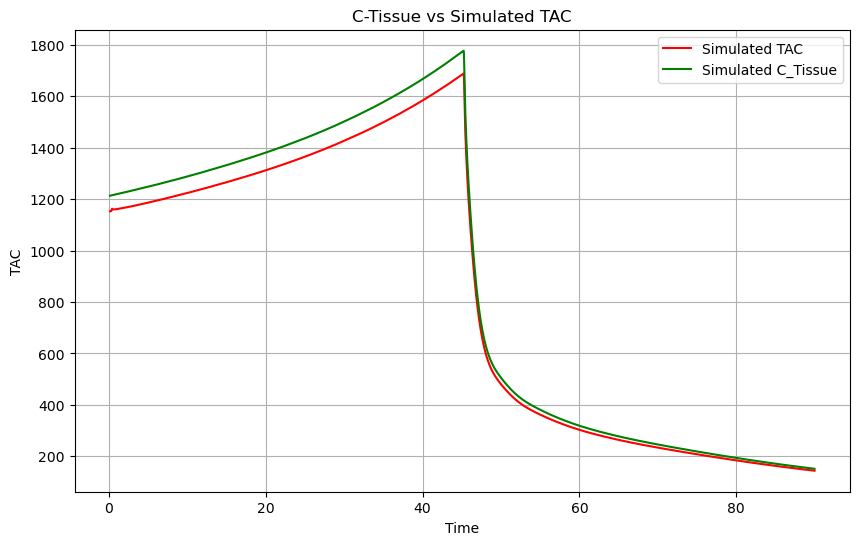

In [24]:
simulated_tac_values = simulated_tac(simulated_c_tissue_values, data_from_first_row['gt_parameters_list'], pchip_bl)
print("Simulated TAC:", simulated_tac_values)
print("CTissue:" , simulated_c_tissue_values)

# Plot the simulated C_Tissue values against the original TAC values
plt.figure(figsize=(10, 6))
plt.plot(new_rtim, simulated_tac_values, label='Simulated TAC', color='red')
plt.plot(new_rtim, simulated_c_tissue_values, label='Simulated C_Tissue', color='green')
plt.xlabel('Time')
plt.ylabel('TAC')
plt.title('C-Tissue vs Simulated TAC')
plt.legend()
plt.grid(True)
plt.show()